*** Based on the code from Chapter 18 Reinforcement Learning by Aurelin Geron.***
Make sure you are using the 3rd Edition!
And the code is from
https://github.com/ageron

# Setup

This project requires Python 3.7 or above:

In [1]:
import sys
assert sys.version_info >= (3, 7)

**Warning**: the latest TensorFlow versions are based on Keras 3. For chapters 10-15, it wasn't too hard to update the code to support Keras 3, but unfortunately it's much harder for this chapter, in particular adding custom losses using the functional API is not implemented yet. So for this chapter I've had to revert to Keras 2. To do that, I set the `TF_USE_LEGACY_KERAS` environment variable to `"1"` and import the `tf_keras` package. This ensures that `tf.keras` points to `tf_keras`, which is Keras 2.*.

In [2]:
IS_COLAB = "google.colab" in sys.modules
if IS_COLAB:
    import os
    os.environ["TF_USE_LEGACY_KERAS"] = "1"
    import tf_keras

And TensorFlow ≥ 2.8:

In [3]:
from packaging import version
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

Define the default font sizes for plots.

In [4]:
import matplotlib.animation
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('animation', html='jshtml')

And let's create the `images/rl` folder (if it doesn't already exist), and define the `save_fig()` function which is used through this notebook to save the figures in high-res for the book:

In [5]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "rl"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Check for GPU

In [6]:
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. Neural nets can be very slow without a GPU.")
    if "google.colab" in sys.modules:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
    if "kaggle_secrets" in sys.modules:
        print("Go to Settings > Accelerator and select GPU.")

Install the Gymnasium library.

**Important notes:**
* OpenAI has handed over the maintenance and developmnent of the Gym library to the Farama foundation (see the [announcement](https://farama.org/Announcing-The-Farama-Foundation)), and the library was renamed to Gymnasium. It's a drop-in replacement for OpenAI Gym: you can just install `gymnasium` instead of `gym`, and `import gymnasium as gym`, and everything should work fine.
* by running the following cell, you accept the Atari ROM license.

In [7]:
if "google.colab" in sys.modules or "kaggle_secrets" in sys.modules:
    !pip install -q -U gymnasium[box2D, atari]
    #!pip install -q -U gymnasium[atari]
    !pip install ale-py

ERROR: Invalid requirement: 'gymnasium[box2D,': Expected extra name after comma
    gymnasium[box2D,
                    ^


# Introduction to ~OpenAI gym~ Gymnasium

In [8]:
!pip install ale-py
import gymnasium as gym


env = gym.make("CartPole-v1", render_mode="rgb_array")

The CartPole (version 1) is a very simple environment composed of a cart that can move left or right, and pole placed vertically on top of it. The agent must move the cart left or right to keep the pole upright.

**Tip**: `gym.envs.registry` is a dictionary containing all available environments:

In [9]:
# extra code – shows the first few environments
envs = gym.envs.registry
sorted(envs.keys())[:5] + ["..."]

['Acrobot-v1', 'Ant-v2', 'Ant-v3', 'Ant-v4', 'Ant-v5', '...']

The registry values are environment specifications:

In [10]:
# extra code – shows the specification for the CartPole-v1 environment
envs["CartPole-v1"]

EnvSpec(id='CartPole-v1', entry_point='gymnasium.envs.classic_control.cartpole:CartPoleEnv', reward_threshold=475.0, nondeterministic=False, max_episode_steps=500, order_enforce=True, disable_env_checker=False, kwargs={}, namespace=None, name='CartPole', version=1, additional_wrappers=(), vector_entry_point='gymnasium.envs.classic_control.cartpole:CartPoleVectorEnv')

Let's initialize the environment by calling is `reset()` method. This returns an observation, as well as a dictionary that may contain extra information. Both are environment-specific.

In [11]:
obs, info = env.reset(seed=42)
obs

array([ 0.0273956 , -0.00611216,  0.03585979,  0.0197368 ], dtype=float32)

In [12]:
info

{}

In the case of the CartPole, each observation is a 1D NumPy array composed of 4 floats: they represent the cart's horizontal position, its velocity, the angle of the pole (0 = vertical), and the angular velocity.

An environment can be visualized by calling its `render()` method. If you set `render_mode` to `"rgb_array"` when creating the environment, then this will return a NumPy array.

In [13]:
img = env.render()
img.shape  # height, width, channels (3 = Red, Green, Blue)

(400, 600, 3)

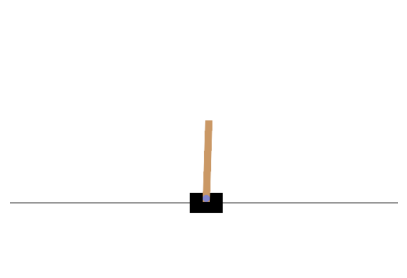

In [14]:
# extra code – creates a little function to render and plot an environment

def plot_environment(env, figsize=(5, 4)):
    plt.figure(figsize=figsize)
    img = env.render()
    plt.imshow(img)
    plt.axis("off")
    return img

plot_environment(env)
plt.show()

In [15]:
env.action_space

Discrete(2)

Yep, just two possible actions: accelerate towards the left (0) or towards the right (1).

Since the pole is leaning toward the right (`obs[2] > 0`), let's accelerate the cart toward the right:

In [16]:
action = 1  # accelerate right
obs, reward, done, truncated, info = env.step(action)
obs

array([ 0.02727336,  0.18847767,  0.03625453, -0.26141977], dtype=float32)

Looks like it's doing what we're telling it to do!

The environment also tells the agent how much reward it got during the last step:

In [17]:
reward

1.0

When the game is over, the environment returns `done=True`. In this case, it's not over yet:

In [18]:
done

False

Some environment wrappers may want to interrupt the environment early. For example, when a time limit is reached or when an object goes out of bounds. In this case, `truncated` will be set to `True`. In this case, it's not truncated yet:

In [19]:
truncated

False

Finally, `info` is an environment-specific dictionary that can provide some extra information that you may find useful for debugging or for training. For example, in some games it may indicate how many lives the agent has.

In [20]:
info

{}

The sequence of steps between the moment the environment is reset until it is done or truncated is called an "episode". At the end of an episode (i.e., when `step()` returns `done=True` or `truncated=True`), you should reset the environment before you continue to use it.

In [21]:
if done or truncated:
    obs, info = env.reset()

Now how can we make the poll remain upright? We will need to define a _policy_ for that. This is the strategy that the agent will use to select an action at each step. It can use all the past actions and observations to decide what to do.

In [22]:
import tensorflow as tf

# Deep Q-Network

Let's build the DQN. Given a state, it will estimate, for each possible action, the sum of discounted future rewards it can expect after it plays that action (but before it sees its outcome):

In [23]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on the CPU

input_shape = [4]  # == env.observation_space.shape
n_outputs = 2  # == env.action_space.n

model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation="elu", input_shape=input_shape),
    tf.keras.layers.Dense(32, activation="elu"),
    tf.keras.layers.Dense(n_outputs)
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                160       
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 2)                 66        
                                                                 
Total params: 1282 (5.01 KB)
Trainable params: 1282 (5.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


To select an action using this DQN, we just pick the action with the largest predicted Q-value. However, to ensure that the agent explores the environment, we choose a random action with probability `epsilon`.

In [24]:
def epsilon_greedy_policy(state, epsilon=0):
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs)  # random action
    else:
        Q_values = model.predict(state[np.newaxis], verbose=0)[0]
        return Q_values.argmax()  # optimal action according to the DQN

We will also need a replay buffer. It will contain the agent's experiences, in the form of tuples: `(obs, action, reward, next_obs, done)`. We can use the `deque` class for that:

In [25]:
from collections import deque

replay_buffer = deque(maxlen=2000)

**Note**: for very large replay buffers, you may want to use a circular buffer instead, as random access time will be O(1) instead of O(N). Or you can check out DeepMind's [Reverb library](https://github.com/deepmind/reverb).

In [26]:
# extra code – A basic circular buffer implementation

class ReplayBuffer:
    def __init__(self, max_size):
        self.buffer = np.empty(max_size, dtype=object)
        self.max_size = max_size
        self.index = 0
        self.size = 0

    def append(self, obj):
        self.buffer[self.index] = obj
        self.size = min(self.size + 1, self.max_size)
        self.index = (self.index + 1) % self.max_size

    def sample(self, batch_size):
        indices = np.random.randint(self.size, size=batch_size)
        return self.buffer[indices]


And let's create a function to sample experiences from the replay buffer. It will return 6 NumPy arrays: `[obs, actions, rewards, next_obs, dones, truncateds]`.

In [27]:
def sample_experiences(batch_size, debug=0):
    indices = np.random.randint(len(replay_buffer), size=batch_size)
    batch = [replay_buffer[index] for index in indices]
    return [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(6)
    ]  # [states, actions, rewards, next_states, dones, truncateds]

Now we can create a function that will use the DQN to play one step, and record its experience in the replay buffer:

In [28]:
def play_one_step(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, done, truncated, info = env.step(action)
    replay_buffer.append((state, action, reward, next_state, done, truncated))
    return next_state, reward, done, truncated, info

Lastly, let's create a function that will sample some experiences from the replay buffer and perform a training step:

In [29]:
import numpy as np

In [30]:
# extra code – for reproducibility, and to generate the next figure
env.reset(seed=42)
np.random.seed(42)
tf.random.set_seed(42)
rewards = []
best_score = 0

In [31]:
batch_size = 32
discount_factor = 0.95
optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-2)
loss_fn = tf.keras.losses.mean_squared_error

def training_step(batch_size, debug):
    experiences = sample_experiences(batch_size, debug)
    states, actions, rewards, next_states, dones, truncateds = experiences
    next_Q_values = model.predict(next_states, verbose=0)
    max_next_Q_values = next_Q_values.max(axis=1)
    runs = 1.0 - (dones | truncateds)  # episode is not done or truncated
    target_Q_values = rewards + runs * discount_factor * max_next_Q_values
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

And now, let's train the model!

In [32]:
for episode in range(300):
    obs, info = env.reset()
    debug = 1

    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, truncated, info = play_one_step(env, obs, epsilon)
        if done or truncated:
            break

    # extra code – displays debug info, stores data for the next figure, and
    #              keeps track of the best model weights so far
    #print(f"\rEpisode: {episode + 1}, Steps: {step + 1}, eps: {epsilon:.3f}",
    #      end="")
    rewards.append(step)
    if step >= best_score:
        best_weights = model.get_weights()
        best_score = step

    if episode > 50:
        training_step(batch_size,debug)
        debug=0

model.set_weights(best_weights)  # extra code – restores the best model weights

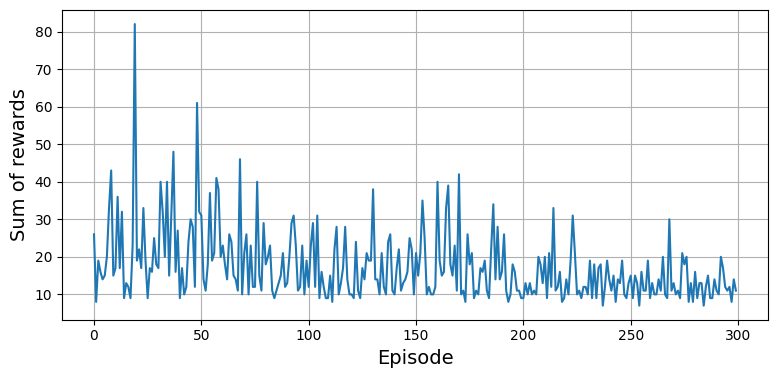

In [33]:
# extra code – this cell generates and saves Figure 18–10
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.grid(True)
save_fig("dqn_rewards_plot")
plt.show()